In [2]:
from GHMiner import GitHubMiner
from GLMiner import GitLabMiner
import pandas as pd
import numpy as np
import openai
import glob
import json
import time
import os


In [3]:
tools_repo = {
    'Aim': 'aimhubio/aim',
    'Amazon SageMaker': 'aws/sagemaker-python-sdk',
    'Azure Machine Learning': 'Azure/azure-sdk-for-python',
    'ClearML': 'allegroai/clearml',
    'Codalab': 'codalab/codalab-worksheets',
    'DVC': 'iterative/dvc',
    'Determined': 'determined-ai/determined',
    'Domino': 'dominodatalab/python-domino',
    'Guild AI': 'guildai/guildai',
    'Kedro': 'kedro-org/kedro',
    'MLflow': 'mlflow/mlflow',
    'MLRun': 'mlrun/mlrun',
    'ModelDB': 'VertaAI/modeldb',
    'Neptune': 'neptune-ai/neptune-client',
    'Polyaxon': 'polyaxon/polyaxon',
    'Sacred': 'IDSIA/sacred',
    'Valohai': 'valohai/valohai-cli',
    'Weights & Biases': 'wandb/wandb'
}

tools_release_date = {
    'Amazon SageMaker': '2017-11-19',
    'Azure Machine Learning': '2015-02-18',
    'cnvrg.io': '2020-03-31',
    'Comet': '2017-01-01',
    'Iterative Studio': '2021-05-12',
    'Polyaxon': '2018-10-16',
    'SigOpt': '2014-11-01',
    'Vertex AI': '2019-03-01'
}

tools_link = {
    'cnvrg.io': 'https://github.com/cnvrg',
    'Comet': 'https://github.com/comet-ml',
    'Iterative Studio': 'https://studio.iterative.ai',
    'SigOpt': 'https://github.com/sigopt',
    'Vertex AI': 'https://cloud.google.com/vertex-ai'
}

tools_keywords = {
    'Aim': {'aim'},
    'Amazon SageMaker': {'sagemaker'},
    'Azure Machine Learning': {'azureml'},
    'ClearML': {'clearml'},
    'cnvrg.io': {'cnvrg'},
    'Codalab': {'codalab'},
    'Comet': {'comet'},
    'Determined': {'determined'},
    'Domino': {'domino'},
    'DVC': {'dvc'},
    'Guild AI': {'guild ai'},
    'Kedro': {'kedro'},
    'MLflow': {'mlflow'},
    'MLRun': {'mlrun'},
    'ModelDB': {'modeldb'},
    'Neptune': {'neptune'},
    'Polyaxon': {'polyaxon'},
    'Sacred': {'sacred'},
    'SigOpt': {'sigopt'},
    'Valohai': {'valohai'},
    'Vertex AI': {'vertex ai'},
    'Weights & Biases': {'wandb', 'weights & biases', 'weights and biases'}
}

ignore_tools = {

}

issue_labels = {
    'bug',
    'invalid',
    'looking into it',
    'waiting feedback',
}


In [4]:
path_dataset = '../Dataset'

path_github = os.path.join(path_dataset, 'GitHub')
path_gitlab = os.path.join(path_dataset, 'GitLab')
path_labels = os.path.join(path_dataset, 'Labels')

path_github_repo = os.path.join(path_github, 'Repo')
path_gitlab_repo = os.path.join(path_gitlab, 'Repo')
path_github_repo_raw = os.path.join(path_github_repo, 'Raw')
path_gitlab_repo_raw = os.path.join(path_gitlab_repo, 'Raw')
path_github_repo_scraped = os.path.join(path_github_repo, 'Scraped')
path_gitlab_repo_scraped = os.path.join(path_gitlab_repo, 'Scraped')

path_github_issue = os.path.join(path_github, 'Issue')
path_gitlab_issue = os.path.join(path_gitlab, 'Issue')
path_github_issue_raw = os.path.join(path_github_issue, 'Raw')
path_gitlab_issue_raw = os.path.join(path_gitlab_issue, 'Raw')
path_github_issue_filtered = os.path.join(path_github_issue, 'Filtered')
path_gitlab_issue_filtered = os.path.join(path_gitlab_issue, 'Filtered')
path_github_issue_sampled = os.path.join(path_github_issue, 'Sampled')
path_gitlab_issue_sampled = os.path.join(path_gitlab_issue, 'Sampled')

if not os.path.exists(path_github):
    os.makedirs(path_github)

if not os.path.exists(path_gitlab):
    os.makedirs(path_gitlab)

if not os.path.exists(path_labels):
    os.makedirs(path_labels)

if not os.path.exists(path_github_repo):
    os.makedirs(path_github_repo)

if not os.path.exists(path_gitlab_repo):
    os.makedirs(path_gitlab_repo)

if not os.path.exists(path_github_issue):
    os.makedirs(path_github_issue)

if not os.path.exists(path_gitlab_issue):
    os.makedirs(path_gitlab_issue)

if not os.path.exists(path_github_repo_raw):
    os.makedirs(path_github_repo_raw)

if not os.path.exists(path_gitlab_repo_raw):
    os.makedirs(path_gitlab_repo_raw)

if not os.path.exists(path_github_issue_raw):
    os.makedirs(path_github_issue_raw)

if not os.path.exists(path_gitlab_issue_raw):
    os.makedirs(path_gitlab_issue_raw)

if not os.path.exists(path_github_issue_sampled):
    os.makedirs(path_github_issue_sampled)

if not os.path.exists(path_gitlab_issue_sampled):
    os.makedirs(path_gitlab_issue_sampled)

if not os.path.exists(path_github_issue_filtered):
    os.makedirs(path_github_issue_filtered)

if not os.path.exists(path_gitlab_issue_filtered):
    os.makedirs(path_gitlab_issue_filtered)

if not os.path.exists(path_github_repo_scraped):
    os.makedirs(path_github_repo_scraped)

if not os.path.exists(path_gitlab_repo_scraped):
    os.makedirs(path_gitlab_repo_scraped)

In [5]:
openai.api_key = os.getenv('OPENAI_API_KEY')

GITHUB_TOKEN = os.getenv('GITHUB_TOKEN')
GITLAB_TOKEN = os.getenv('GITLAB_TOKEN')

github_miner = GitHubMiner(private_token=GITHUB_TOKEN)
gitlab_miner = GitLabMiner(private_token=GITLAB_TOKEN)

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


In [6]:
tools_data = pd.DataFrame()

# scrape open-source asset-management tools
for tool_name, tool_repo in tools_repo.items():
    if tool_name in tools_release_date:
        tool_data, error_data = github_miner.scrape_repo(
            repo_name=tool_repo, real_name=tool_name, release_date=pd.to_datetime(tools_release_date[tool_name]))
    else:
        tool_data, error_data = github_miner.scrape_repo(
            repo_name=tool_repo, real_name=tool_name)

    if not tool_data.empty:
        tools_data = pd.concat([tools_data, tool_data], ignore_index=True)
    else:
        print(error_data)

# add closed-source asset-management tools
for tool_name in tools_link.keys():
    tool_data = {
        'Name': tool_name,
        'Link': tools_link[tool_name],
        'First Release Date': pd.to_datetime(tools_release_date[tool_name])
    }
    tool_data = pd.DataFrame([tool_data])
    tools_data = pd.concat([tools_data, tool_data], ignore_index=True)

tools_data.to_json(os.path.join(path_dataset, 'Tools.json'),
                   indent=4, orient='records')
tools_data


,Repo,Link,Repo Creation Date,Last Commit Date,Topics,Language,Size,#Star,#Watch,#Fork,#Contributors,#Branches,#Releases,#Commits,#Pull Requests,#Pull Requests (Open),#Issues,#Issues (Open),Name,First Release Date
0,aimhubio/aim,https://github.com/aimhubio/aim,2019-05-31 18:25:07,2023-01-31 12:13:08,"[python, ai, data-science, data-visualization,...",TypeScript,59947.0,3065.0,36.0,191.0,50.0,77.0,46.0,2009.0,1708.0,21.0,2491.0,223.0,Aim,2022-01-22 13:45:58
1,aws/sagemaker-python-sdk,https://github.com/aws/sagemaker-python-sdk,2017-11-14 01:03:33,2023-01-31 01:53:20,"[aws, mxnet, tensorflow, machine-learning, pyt...",Python,108723.0,1770.0,132.0,926.0,309.0,15.0,479.0,2850.0,2294.0,51.0,3458.0,455.0,Amazon SageMaker,2017-11-19 00:00:00
2,Azure/azure-sdk-for-python,https://github.com/Azure/azure-sdk-for-python,2012-04-24 16:46:12,2023-02-01 02:54:36,"[python, azure, azure-sdk, hacktoberfest]",Python,537971.0,3473.0,362.0,2186.0,398.0,583.0,2697.0,13516.0,20859.0,145.0,28484.0,927.0,Azure Machine Learning,2015-02-18 00:00:00
3,allegroai/clearml,https://github.com/allegroai/clearml,2019-06-10 08:18:32,2023-01-26 17:11:47,"[version-control, experiment-manager, version,...",Python,42437.0,4027.0,83.0,542.0,62.0,3.0,75.0,1979.0,180.0,2.0,890.0,333.0,ClearML,2019-06-11 17:27:11
4,codalab/codalab-worksheets,https://github.com/codalab/codalab-worksheets,2014-11-30 22:33:18,2023-01-29 22:07:50,[],Python,28204.0,135.0,18.0,79.0,54.0,133.0,114.0,4541.0,2242.0,30.0,4366.0,382.0,Codalab,2017-05-14 00:32:55
5,iterative/dvc,https://github.com/iterative/dvc,2017-03-04 08:16:33,2023-02-01 03:25:50,"[data-science, machine-learning, reproducibili...",Python,17626.0,11008.0,136.0,1024.0,254.0,10.0,415.0,8365.0,4544.0,8.0,8652.0,626.0,DVC,2017-05-04 08:03:08
6,determined-ai/determined,https://github.com/determined-ai/determined,2020-04-07 16:12:29,2023-02-01 03:19:51,"[deep-learning, machine-learning, ml-platform,...",Python,108561.0,2024.0,62.0,276.0,73.0,182.0,76.0,4923.0,5637.0,65.0,5891.0,86.0,Determined,2020-04-08 20:01:20
7,dominodatalab/python-domino,https://github.com/dominodatalab/python-domino,2016-05-16 22:58:02,2023-01-17 21:37:32,[],Python,488.0,51.0,28.0,50.0,32.0,52.0,14.0,201.0,132.0,4.0,167.0,15.0,Domino,2020-08-05 05:16:39
8,guildai/guildai,https://github.com/guildai/guildai,2017-09-27 18:57:50,2023-01-25 14:47:47,[],Python,16971.0,771.0,13.0,71.0,20.0,65.0,2.0,5382.0,69.0,1.0,467.0,185.0,Guild AI,2022-04-28 14:31:07
9,kedro-org/kedro,https://github.com/kedro-org/kedro,2019-04-18 10:29:56,2023-01-30 10:11:12,"[pipeline, kedro, hacktoberfest, mlops, experi...",Python,165970.0,8041.0,102.0,760.0,169.0,32.0,34.0,2148.0,972.0,16.0,2064.0,245.0,Kedro,2019-06-03 16:15:43


In [ ]:
dependents = pd.DataFrame()

# collect dependents for tools with coding patterns
for tool_name in tools_keywords.keys():
    github_dependents = []
    gitlab_dependents = []

    # collect Github dependents
    file_name = os.path.join(path_github_repo_raw, tool_name + '.json')
    if os.path.exists(file_name):
        with open(file_name, encoding='utf8') as json_file:
            json_data = json.load(json_file)
            # either search by sourcegraph
            if 'Results' in json_data:
                for repo_file in json_data['Results']:
                    # file name match pattern
                    if 'FileMatch' == repo_file['__typename'] and repo_file['repository']['name'].startswith('github'):
                        repo_name = repo_file['repository']['name'].removeprefix(
                            'github.com/')
                        github_dependents.append(repo_name)
                    # code usage match pattern
                    elif 'Repository' == repo_file['__typename'] and repo_file['name'].startswith('github'):
                        repo_name = repo_file['name'].removeprefix(
                            'github.com/')
                        github_dependents.append(repo_name)
            # or search by dependent graph
            elif 'all_public_dependent_repos' in json_data:
                for repo_file in json_data['all_public_dependent_repos']:
                    github_dependents.append(repo_file['name'])

    # collect Gitlab dependents
    file_name = os.path.join(path_gitlab_repo_raw, tool_name + '.json')
    if os.path.exists(file_name):
        with open(file_name, encoding='utf8') as json_file:
            json_data = json.load(json_file)
            # search by sourcegraph exclusively
            for repo_file in json_data['Results']:
                # file name match pattern
                if 'FileMatch' == repo_file['__typename'] and repo_file['repository']['name'].startswith('gitlab'):
                    repo_name = repo_file['repository']['name'].removeprefix(
                        'gitlab.com/')
                    gitlab_dependents.append(repo_name)
                # code usage match pattern
                elif 'Repository' == repo_file['__typename'] and repo_file['name'].startswith('gitlab'):
                    repo_name = repo_file['name'].removeprefix('gitlab.com/')
                    gitlab_dependents.append(repo_name)

    # remove tool repo from dependents if any
    if tool_name in tools_repo and tools_repo[tool_name] in github_dependents:
        github_dependents.remove(tools_repo[tool_name])

    # no need to add tools without dependents
    if not len(github_dependents) and not len(gitlab_dependents):
        continue

    dependent = {
        'Tool': tool_name,
        'GitHub Dependents': github_dependents,
        'GitLab Dependents': gitlab_dependents
    }

    dependents = pd.concat(
        [dependents, pd.DataFrame([dependent])], ignore_index=True)

dependents.to_json(os.path.join(
    path_dataset, 'Dependents.json'), indent=4, orient='records')


In [10]:
dependents_summary = pd.DataFrame(
    columns=['Tool', '#GitHub Dependents', '#GitLab Dependents'])
for index, row in dependents.iterrows():
    dependent_data = {
        'Tool': row['Tool'],
        '#GitHub Dependents': len(row['GitHub Dependents']),
        '#GitLab Dependents': len(row['GitLab Dependents'])
    }
    dependent_data = pd.DataFrame([dependent_data])
    dependents_summary = pd.concat(
        [dependents_summary, dependent_data], ignore_index=True)
# dependents_summary.sort_values(by=['#GitHub Dependents', '#GitLab Dependents'], ascending=False, inplace=True)
dependents_summary

,Tool,#GitHub Dependents,#GitLab Dependents
0,Aim,92,1
1,Amazon SageMaker,931,3
2,Azure Machine Learning,689,0
3,ClearML,303,0
4,Codalab,30,0
5,Comet,480,0
6,Determined,44,0
7,Domino,2,0
8,DVC,4229,0
9,Guild AI,53,4


In [5]:
df_dependents = pd.read_json(os.path.join(path_dataset, 'Dependents.json'))
df_tools = pd.read_json(os.path.join(path_dataset, 'Tools.json'))


In [ ]:
# scrape Gitlab dependents general information for each tool
for index, row in df_dependents.iterrows():
    print(f'{index}: {row["Tool"]}')
    repos_data, errors_data = gitlab_miner.scrape_repo_list(
        row['GitLab Dependents'])

    if not repos_data.empty:
        repos_data = repos_data.sort_values(by='#Issues', ascending=False)
        repos_data.to_json(os.path.join(
            path_gitlab_repo_scraped, f'{row["Tool"]}.json'), indent=4, orient='records')

    if not errors_data.empty:
        errors_data.to_json(os.path.join(path_gitlab_repo_scraped,
                            f'Discarded.{row["Tool"]}.json'), indent=4, orient='records')

In [ ]:
# scrape issues of Gitlab dependents for each tool
for index, row in df_tools.iterrows():
    file_name = os.path.join(path_gitlab_repo_scraped, f'{row["Name"]}.json')
    if os.path.exists(file_name):
        repos = pd.read_json(file_name)
        # filter out repos without any issues
        repos = repos[repos['#Issues'] > 0]
        # filter out repos created before the tool's first release date
        repos = repos[repos['Repo Creation Date'] > row['First Release Date']]
        print(f'{row["Name"]}: {repos["#Issues"].sum()}')
        # scrape issues for the current tool
        issues = gitlab_miner.scrape_issue_list(repos['Repo'].tolist())
        if not issues.empty:
            issues.to_json(os.path.join(path_gitlab_issue_raw,
                                        f'{row["Name"]}.json'), indent=4, orient='records')


In [14]:
# exclude Gitlab issues that are not related to each tool
valid_issues_all = pd.DataFrame()
valid_fixes_all = pd.DataFrame()

for file_name in glob.glob(os.path.join(path_gitlab_issue_raw, '*.json')):
    issues = pd.read_json(file_name)
    valid_issues = pd.DataFrame()
    valid_fixes = pd.DataFrame()
    tool_name = os.path.split(file_name)[1].split('.')[0]

    for index, issue in issues.iterrows():
        for keyword in tools_keywords[tool_name]:
            if keyword in issue['Issue_title'].lower():
                valid_issue = pd.DataFrame([issue])
                valid_issues = pd.concat(
                    [valid_issues, valid_issue], ignore_index=True)
                if not pd.isnull(issue['Issue_closed_time']):
                    valid_fixes = pd.concat(
                        [valid_fixes, valid_issue], ignore_index=True)
                break

    if not valid_issues.empty:
        valid_issues['Tool'] = tool_name
        valid_issues_all = pd.concat(
            [valid_issues_all, valid_issues], ignore_index=True)
        if not valid_fixes.empty:
            valid_fixes['Tool'] = tool_name
            valid_fixes_all = pd.concat(
                [valid_fixes_all, valid_fixes], ignore_index=True)

valid_issues_all = valid_issues_all[~valid_issues_all['Tool'].isin(
    ignore_tools)]
valid_fixes_all = valid_fixes_all[~valid_fixes_all['Tool'].isin(ignore_tools)]
valid_issues_all.head()


,Issue_link,Issue_title,Issue_label,Issue_creation_time,Issue_closed_time,Issue_upvote_count,Issue_downvote_count,Issue_body,Tool
0,https://gitlab.com/fluidattacks/universe/-/iss...,[Sorts] Add sagemaker dependencies,"[arena::security, product::sorts, type::bug]",2022-12-19 20:28:18.985,NaT,0,0,"<!-- Issues are public, they should not contai...",Amazon SageMaker
1,https://gitlab.com/fluidattacks/universe/-/iss...,Enable sagemaker,[],2020-04-21 18:40:24.230,2020-05-07 21:34:48.408,0,0,https://docs.aws.amazon.com/sagemaker/,Amazon SageMaker
2,https://gitlab.com/librespacefoundation/polari...,Saving behave logs in MLflow,[],2021-07-06 19:33:14.309,NaT,0,0,"Like we do in learn, we should also save the p...",MLflow
3,https://gitlab.com/librespacefoundation/polari...,ML Database vs. MLflow,[learn],2020-04-25 17:51:29.061,NaT,1,0,I am mainly working on the feature selection p...,MLflow
4,https://gitlab.com/librespacefoundation/polari...,Namespacing polaris runs for logging purposes ...,"[improvement, learn]",2020-01-31 21:57:59.518,NaT,0,0,Background\n==========\n\nEverytime analysis i...,MLflow


In [15]:
final = set()
for _, row in valid_issues_all['Issue_label'].map(set).items():
    final = final.union(row)
final

{'arena::security', 'improvement', 'learn', 'product::sorts', 'type::bug'}

In [20]:
# filter out issues that are not related to challenges
valid_issues_filtered = []
valid_fixes_filtered = []

for index, row in valid_issues_all.iterrows():
    if not row['Issue_title'].isascii():
        continue
       
    break_sign = False
    for label_repo in row['Issue_label']:
        for label_question in issue_labels:
            if not break_sign and label_question in label_repo.lower():
                valid_issues_filtered.append(row)
                break_sign = True

for index, row in valid_fixes_all.iterrows():
    if not row['Issue_title'].isascii():
        continue
       
    break_sign = False
    for label_repo in row['Issue_label']:
        for label_question in issue_labels:
            if not break_sign and label_question in label_repo.lower():
                valid_fixes_filtered.append(row)
                break_sign = True

valid_issues_filtered = pd.concat(valid_issues_filtered, axis=1).T
valid_issues_filtered.to_json(os.path.join(
    path_gitlab_issue_filtered, 'issues.json'), indent=4, orient='records')

if valid_fixes_filtered:
    valid_fixes_filtered = pd.concat(valid_fixes_filtered, axis=1).T
    valid_fixes_filtered.to_json(os.path.join(
        path_gitlab_issue_filtered, 'fixes.json'), indent=4, orient='records')


In [22]:
summary_issues = valid_issues_filtered.groupby(
    'Tool').count()['Issue_title'].reset_index()
summary_issues.rename(columns={'Issue_title': '#Issue'}, inplace=True)
summary_issues = summary_issues.astype({'#Issue': 'int32'})
summary_issues.to_csv(os.path.join(
    path_gitlab_issue, 'summary.csv'), index=False)
summary_issues


,Tool,#Issue
0,Amazon SageMaker,1


In [23]:
# After having the population for each tool and discussion channel, we then find out the minimum number of necessary samples with the [calculator](https://www.calculator.net/sample-size-calculator.html).
df_summary = pd.read_csv(os.path.join(path_gitlab_issue, 'summary.csv'))
df_summary

,Tool,#Issue,#Sample Issue
0,Amazon SageMaker,1,1


In [20]:
# sample Gitlab issues and fixes accordingly
df_issue_samples = pd.DataFrame()
df_fix_samples = pd.DataFrame()

for index, row in df_summary.iterrows():
    df_issue_sample = valid_issues_filtered[valid_issues_filtered['Tool'] == row['Tool']].sample(
        n=row['#Sample Issue'], random_state=0)
    df_fix_sample = valid_fixes_filtered[valid_fixes_filtered['Tool'] == row['Tool']].sample(
        n=row['#Sample Closed'], random_state=0)
    df_issue_samples = pd.concat(
        [df_issue_samples, df_issue_sample], ignore_index=True)
    df_fix_samples = pd.concat(
        [df_fix_samples, df_fix_sample], ignore_index=True)

df_issue_samples.to_json(os.path.join(
    path_gitlab_issue_sampled, 'issues.json'), indent=4, orient='records')
df_fix_samples.to_json(os.path.join(
    path_gitlab_issue_sampled, 'fixes.json'), indent=4, orient='records')


In [21]:
# concatenate Gitlab fixed and unfixed posts
df_issue_samples = pd.read_json(os.path.join(path_gitlab_issue_sampled, 'issues.json'))
df_fix_samples = pd.read_json(os.path.join(path_gitlab_issue_sampled, 'fixes.json'))

df_issue_samples.drop(['Issue_label'], axis=1, inplace=True)
df_fix_samples.drop(['Issue_label'], axis=1, inplace=True)

df_issue_samples_gitlab = pd.merge(df_issue_samples, df_fix_samples, on=df_issue_samples.columns.tolist(), how='outer')
df_issue_samples_gitlab.to_json(os.path.join(path_labels, 'issues_gitlab.json'), indent=4, orient='records')

In [ ]:
# scrape Github dependents general information for each tool
for index, row in df_dependents.iterrows():
    print(f'{index}: {row["Tool"]}')
    repos_data, errors_data = github_miner.scrape_repo_list(
        row['GitHub Dependents'])

    if not repos_data.empty:
        repos_data = repos_data.sort_values(by='#Issues', ascending=False)
        repos_data.to_json(os.path.join(
            path_github_repo_scraped, f'{row["Tool"]}.json'), indent=4, orient='records')

    if not errors_data.empty:
        errors_data.to_json(os.path.join(path_github_repo_scraped,
                            f'Discarded.{row["Tool"]}.json'), indent=4, orient='records')

In [ ]:
# scrape issues of Github dependents for each tool
for index, row in df_tools.iterrows():
    file_name = os.path.join(path_github_repo_scraped, f'{row["Name"]}.json')
    if os.path.exists(file_name):
        repos = pd.read_json(file_name)
        # filter out repos with only pr-based issues
        repos = repos[repos['#Issues'] > repos['#Pull Requests']]
        # filter out repos created before the tool's first release date
        repos = repos[repos['Repo Creation Date'] > row['First Release Date']]
        print(
            f'{row["Name"]}: {repos["#Issues"].sum() - repos["#Pull Requests"].sum()}')
        # scrape issues for the current tool
        issues = github_miner.scrape_issue_list(repos['Repo'].tolist())
        if not issues.empty:
            issues.to_json(os.path.join(path_github_issue_raw,
                           f'{row["Name"]}.json'), indent=4, orient='records')


In [78]:
# exclude Github issues that are not related to each tool
valid_issues_all = pd.DataFrame()
valid_fixes_all = pd.DataFrame()

for file_name in glob.glob(os.path.join(path_github_issue_raw, '*.json')):
    issues = pd.read_json(file_name)
    valid_issues = pd.DataFrame()
    valid_fixes = pd.DataFrame()
    tool_name = os.path.split(file_name)[1].split('.')[0]

    for index, issue in issues.iterrows():
        for keyword in tools_keywords[tool_name]:
            if keyword in issue['Issue_title'].lower():
                valid_issue = pd.DataFrame([issue])
                valid_issues = pd.concat(
                    [valid_issues, valid_issue], ignore_index=True)
                if not pd.isnull(issue['Issue_closed_time']):
                    valid_fixes = pd.concat(
                        [valid_fixes, valid_issue], ignore_index=True)
                break

    if not valid_issues.empty:
        valid_issues['Tool'] = tool_name
        valid_issues_all = pd.concat(
            [valid_issues_all, valid_issues], ignore_index=True)
        if not valid_fixes.empty:
            valid_fixes['Tool'] = tool_name
            valid_fixes_all = pd.concat(
                [valid_fixes_all, valid_fixes], ignore_index=True)

valid_issues_all = valid_issues_all[~valid_issues_all['Tool'].isin(
    ignore_tools)]
valid_fixes_all = valid_fixes_all[~valid_fixes_all['Tool'].isin(ignore_tools)]
valid_issues_all.head()


,Issue_link,Issue_title,Issue_label,Issue_creation_time,Issue_closed_time,Issue_upvote_count,Issue_downvote_count,Issue_comment_count,Issue_body,Tool
0,https://github.com/h2oai/dai-deployment-templa...,[Feature Request] Propagate mojo scorer images...,[WIP - Susankha],2021-11-10 19:28:00,NaT,0,0,2,### Request:\r\nThis request is a follow up to...,Amazon SageMaker
1,https://github.com/h2oai/dai-deployment-templa...,[AWS/Sagemaker] Reduce Code Base,[],2020-02-13 21:07:27,NaT,0,0,0,After research stemming from gcp deployment me...,Amazon SageMaker
2,https://github.com/utterworks/fast-bert/issues...,Issue with finetuning pretraining Language mo...,[],2020-10-21 14:28:14,NaT,0,0,0,Hi Iam using the container_lm code base to fin...,Amazon SageMaker
3,https://github.com/utterworks/fast-bert/issues...,Error for training job failed. reason: algorit...,[],2020-10-03 13:37:14,2020-10-09 17:13:38,0,0,1,"Hello, \r\n\r\nI was training a DistilBERT mod...",Amazon SageMaker
4,https://github.com/utterworks/fast-bert/issues...,Using multiple training instances in AWS Sagem...,[],2020-04-23 12:22:33,NaT,0,0,4,Is it possible to speedup BERT training by usi...,Amazon SageMaker


In [29]:
final = set()
for _, row in valid_issues_all['Issue_label'].map(set).items():
    final = final.union(row)
final

{'"experiments"',
 '0.4.6',
 '1.1',
 '1.4',
 '1.6',
 '1.7',
 '3 - Quality of Life',
 '3rd party',
 '3rd party update',
 ':bridge_at_night:  Bridge',
 ':bug: bug',
 ':rotating_light:',
 '? - Needs Triage',
 'A: example-dvc-experiments',
 'A: example-get-started',
 'ADO',
 'AI\u202fFrameworks/ONNX',
 'AML Compute Instance',
 'API',
 'API & Doc',
 'Auto\u202fML',
 'Cloud',
 'Community',
 'Compute',
 'Core UI',
 'DRL',
 'Data4ML',
 'Data\u202fDrift',
 'Data\u202fPrep\u202fServices',
 'Documentation',
 'ERRATA_CANDIDATE',
 'Enhancement',
 'Environments',
 'Evaluation',
 'Experimentation UI',
 'FAQ',
 'Feature - Medium Priority',
 'HIGH',
 'HPO',
 'Hyperdrive',
 'Important',
 'In the roadmap',
 'Inf1',
 'Inference',
 'Ingestion',
 'Issue: Bug Report 🐞',
 'Issue: Feature Request',
 'L',
 'LOE: S',
 'Localized',
 'MLOps',
 'NLP',
 'NUM',
 'Needs Triage',
 'Not related to PyCaret',
 'Notebook',
 'Optional',
 'P0',
 'P1',
 'P2',
 'Pipelines',
 'Priority 1',
 'Reinforcement Learning',
 'RepoOffic

In [79]:
# filter out issues that are not related to challenges
valid_issues_filtered = []
valid_fixes_filtered = []

for index, row in valid_issues_all.iterrows():
    if not row['Issue_title'].isascii():
        continue
    
    break_sign = False
    for label_repo in row['Issue_label']:
        for label_question in issue_labels:
            if not break_sign and label_question in label_repo.lower():
                valid_issues_filtered.append(row)
                break_sign = True

for index, row in valid_fixes_all.iterrows():
    if not row['Issue_title'].isascii():
        continue
       
    break_sign = False
    for label_repo in row['Issue_label']:
        for label_question in issue_labels:
            if not break_sign and label_question in label_repo.lower():
                valid_fixes_filtered.append(row)
                break_sign = True

valid_issues_filtered = pd.concat(valid_issues_filtered, axis=1).T
valid_fixes_filtered = pd.concat(valid_fixes_filtered, axis=1).T

valid_issues_filtered.to_json(os.path.join(
    path_github_issue_filtered, 'issues.json'), indent=4, orient='records')
valid_fixes_filtered.to_json(os.path.join(
    path_github_issue_filtered, 'fixes.json'), indent=4, orient='records')


In [31]:
summary_issues = valid_issues_filtered.groupby(
    'Tool').count()['Issue_title'].reset_index()
summary_fixes = valid_fixes_filtered.groupby(
    'Tool').count()['Issue_title'].reset_index()
summary_issues.rename(columns={'Issue_title': '#Issue'}, inplace=True)
summary_fixes.rename(columns={'Issue_title': '#Closed'}, inplace=True)
summary_github = summary_issues.merge(
    summary_fixes, on='Tool', how='outer').fillna(0)
summary_github = summary_github.astype({'#Issue': 'int32', '#Closed': 'int32'})
summary_github.to_csv(os.path.join(
    path_github_issue, 'summary.csv'), index=False)
summary_github


,Tool,#Issue,#Closed
0,Amazon SageMaker,69,57
1,Azure Machine Learning,31,17
2,ClearML,3,2
3,Comet,22,20
4,DVC,29,22
5,Kedro,18,14
6,MLflow,105,89
7,Neptune,12,10
8,SigOpt,4,3
9,Vertex AI,5,4


In [9]:
# After having the population for each tool and discussion channel, we then find out the minimum number of necessary samples with the [calculator](https://www.calculator.net/sample-size-calculator.html).
df_summary = pd.read_csv(os.path.join(path_github_issue, 'summary.csv'))
df_summary

,Tool,#Issue,#Closed,#Sample Issue,#Sample Closed
0,Amazon SageMaker,340,210,181,137
1,Azure Machine Learning,174,120,120,92
2,ClearML,19,12,19,12
3,Comet,43,34,39,32
4,DVC,174,109,120,86
5,Determined,1,0,1,0
6,Kedro,102,58,81,51
7,MLflow,327,233,177,146
8,Neptune,38,32,35,30
9,Sacred,41,19,38,19


In [10]:
# sample Github issues and fixes accordingly
df_issue_samples = pd.DataFrame()
df_fix_samples = pd.DataFrame()

for index, row in df_summary.iterrows():
    df_issue_sample = valid_issues_filtered[valid_issues_filtered['Tool'] == row['Tool']].sample(
        n=row['#Sample Issue'], random_state=0)
    df_fix_sample = valid_fixes_filtered[valid_fixes_filtered['Tool'] == row['Tool']].sample(
        n=row['#Sample Closed'], random_state=0)
    df_issue_samples = pd.concat(
        [df_issue_samples, df_issue_sample], ignore_index=True)
    df_fix_samples = pd.concat(
        [df_fix_samples, df_fix_sample], ignore_index=True)

df_issue_samples.to_json(os.path.join(
    path_github_issue_sampled, 'issues.json'), indent=4, orient='records')
df_fix_samples.to_json(os.path.join(
    path_github_issue_sampled, 'fixes.json'), indent=4, orient='records')


In [11]:
# concatenate Github fixed and unfixed issues
df_issue_samples = pd.read_json(os.path.join(path_github_issue_sampled, 'issues.json'))
df_fix_samples = pd.read_json(os.path.join(path_github_issue_sampled, 'fixes.json'))

df_issue_samples.drop(['Issue_label'], axis=1, inplace=True)
df_fix_samples.drop(['Issue_label'], axis=1, inplace=True)

df_issue_samples_github = pd.merge(df_issue_samples, df_fix_samples, on=df_issue_samples.columns.tolist(), how='outer')
df_issue_samples_github.to_json(os.path.join(path_labels, 'issues_github.json'), indent=4, orient='records')

In [ ]:
# concatenate Github and Gitlab issues
df_issue_samples_gitlab = pd.read_json(os.path.join(path_labels, 'issues_gitlab.json'))
df_issue_samples_github = pd.read_json(os.path.join(path_labels, 'issues_github.json'))

df_fix_samples_gitlab = pd.read_json(os.path.join(path_gitlab_issue_sampled, 'fixes.json'))
df_fix_samples_github = pd.read_json(os.path.join(path_github_issue_sampled, 'fixes.json'))

df_issue_samples_all = pd.concat([df_issue_samples_gitlab, df_issue_samples_github], ignore_index=True)
df_fix_samples_all = pd.concat([df_fix_samples_gitlab, df_fix_samples_github], ignore_index=True)

df_issue_samples_all.to_json(os.path.join(path_labels, 'issues_all.json'), indent=4, orient='records')
df_fix_samples_all.to_json(os.path.join(path_labels, 'fixes_all.json'), indent=4, orient='records')

In [100]:
# create summary field for all issues
issue_github = pd.read_json(os.path.join(path_github_issue_filtered, 'issues.json'))
issue_gitlab = pd.read_json(os.path.join(path_gitlab_issue_filtered, 'issues.json'))
issue_github['Issue_summary'] = ''
issue_gitlab['Issue_summary'] = ''
issue_github.to_json(os.path.join(path_labels, 'issues_prefill_github.json'), indent=4, orient='records')
issue_gitlab.to_json(os.path.join(path_labels, 'issues_prefill_gitlab.json'), indent=4, orient='records')

In [8]:
# manually preprocess the content of the issues and feed them into "text-davinci-003" for summary generation
for index, row in issue_github.iterrows():
    if (len(str(row['Issue_body'])) > 10000):
        print(row['Issue_link'])

https://github.com/autogluon/autogluon/issues/268
https://github.com/awslabs/gluonts/issues/426
https://github.com/kedro-org/kedro/issues/308
https://github.com/zenml-io/zenml/issues/767
https://github.com/microsoft/computervision-recipes/issues/332
https://github.com/microsoft/computervision-recipes/issues/320
https://github.com/Lightning-AI/lightning/issues/9879
https://github.com/databrickslabs/dbx/issues/548
https://github.com/nv-morpheus/Morpheus/issues/512
https://github.com/prinz-nussknacker/prinz/issues/78
https://github.com/pycaret/pycaret/issues/2838
https://github.com/pycaret/pycaret/issues/931
https://github.com/microsoft/qlib/issues/1035
https://github.com/graphnet-team/graphnet/issues/316


In [6]:
issue_github = pd.read_json(os.path.join(path_labels, 'issues_prefill_github.json'))
issue_gitlab = pd.read_json(os.path.join(path_labels, 'issues_prefill_gitlab.json'))
issue_todo_github = issue_github[issue_github['Issue_summary'] == '']
issue_todo_gitlab = issue_gitlab[issue_gitlab['Issue_summary'] == '']
issue_done_github = issue_github[issue_github['Issue_summary'] != '']
issue_done_gitlab = issue_gitlab[issue_gitlab['Issue_summary'] != '']
issue_todo_github.shape[0], issue_todo_gitlab.shape[0]

(299, 0)

In [ ]:
error_requests = []

for index, row in issue_todo_github.iterrows():
    print(f'working on issue {index}')
    try:
        response = openai.Completion.create(
            model='text-davinci-003',
            prompt='Use 1 to 2 sentences to summarize the following text.\n\nText: """' + 'Title: ' +
            row['Issue_title'].str.strip() + '; Content: ' +
            str(row['Issue_body']).strip() + '""""\n\n',
            temperature=0,
            max_tokens=300,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stream=False,
            timeout=10
        )
        issue_todo_github.at[index,
                             'Issue_summary'] = response['choices'][0]['text']
    except Exception as e:
        error_requests.append(index)
    time.sleep(5)

issue_github = pd.concat(
    [issue_todo_github, issue_done_github], ignore_index=True)
issue_github.to_json(os.path.join(
    path_labels, 'issues_fill_github_1.json'), indent=4, orient='records')


In [66]:
issue_github = pd.read_json(os.path.join(path_labels, 'issues_fill_github.json'))
issue_github['Issue_embedding'] = issue_github.apply(lambda x: [], axis=1)

In [132]:
from openai.embeddings_utils import get_embedding

embedding_model = "text-embedding-ada-002"

error_requests = []

#issue_github['Issue_embedding'] = issue_github['Issue_summary'].apply(lambda x: get_embedding(x, engine=embedding_model))

for index, row in issue_github.iterrows():
    if len(row['Issue_embedding']) > 1:
        continue
    print(f'working on issue {index}')
    try:
        response = get_embedding(row['Issue_summary'], engine=embedding_model)
        issue_github.at[index, 'Issue_embedding'] = response
    except Exception as e:
        print(e)
        error_requests.append(index)

working on issue 60
working on issue 61
working on issue 62
working on issue 89
working on issue 132
working on issue 134
working on issue 176
working on issue 208
working on issue 244
working on issue 245
working on issue 291


In [134]:
from sklearn.manifold import TSNE

# Convert to a list of lists of floats
matrix = np.array(issue_github['Issue_embedding'].to_list())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(339, 2)

In [135]:
matrix = np.vstack(issue_github['Issue_embedding'].values)
matrix.shape

(339, 1536)

c:\Users\zhimi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

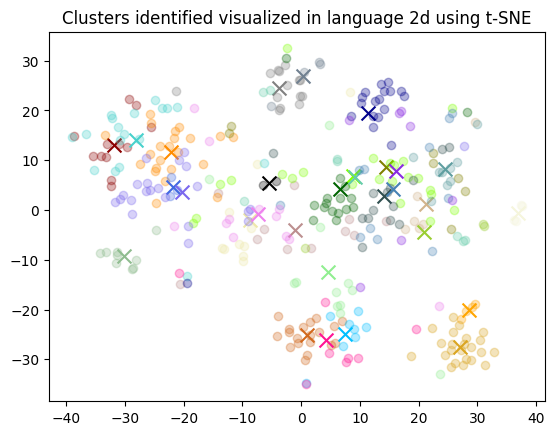

In [139]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

n_clusters = 30

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
issue_github['Issue_cluster'] = labels


tsne = TSNE(n_components=2, perplexity=15, random_state=42,
            init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

color_list = ["black", "grey", "rosybrown", "darkred", "chocolate", "darkorange", "tan", "orange", "goldenrod", "palegoldenrod", "beige", "olive", "yellowgreen", "chartreuse", "darkseagreen", "lightgreen",
              "darkgreen", "mediumaquamarine", "mediumturquoise", "darkslategrey", "cadetblue", "deepskyblue", "steelblue", "slategray", "royalblue", "darkblue", "mediumslateblue", "blueviolet", "violet", "deeppink"]

for category, color in enumerate(color_list):
    xs = np.array(x)[issue_github['Issue_cluster'] == category]
    ys = np.array(y)[issue_github['Issue_cluster'] == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [143]:
# Reading a review which belong to each group.
rev_per_cluster = 2

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        issue_github[issue_github['Issue_cluster'] == i]['Issue_summary'].sample(rev_per_cluster, random_state=42).values
    )
    response = openai.Completion.create(
        engine="text-curie-001",
        prompt=f'What do the following summary have in common?\n\nSummary:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = issue_github[issue_github['Issue_cluster'] == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows['Issue_summary'].values[j])

    print("-" * 100)

Cluster 0 Theme:  Problems with AzureML


The GPU memory utilization metrics are not correctly visible in AzureML Run 2236 in experiment "master" in RadiomicsNN, with only metrics for 3 out of the 4 GPUs visible and all MemAllocated and MemReserved metrics being zero.


Runtime of SASRec integration test is unusually long on AzureML compute cluster.
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  BrokenThe plugin does not work with projects created with a previous version of the plugin.


The plugin does not work with projects created with ``kedro==0.18.1``.


The kedro mlflow cli is broken if configuration is declared in pyproject.toml.
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  Bug report requesting an update to a software package.


Pytorch Lightning 1.2.0 requires a newer version of MLflow in order to work properly.


The bug report is r